In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Model
from keras.applications.vgg19 import VGG19


In [ ]:
import tensorflow as tf

In [ ]:
def gram(tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', tensor, tensor)
    matrix = tf.expand_dims(result, axis=0)
    inputShape = tf.shape(tensor)
    ij = tf.cast(inputShape[1]*inputShape[2], tf.float32)

    return matrix/ij

In [ ]:
def loadVGG():
    vgg = VGG19(include_top=False, weights="imagenet", input_shape=(1024,1024,3))
    vgg.trainable = False
    contentLayers = [ 'block4_conv2']
    styleLayers = [ 'block1_conv1', 'block2_conv1','block3_conv1','block4_conv1','block5_conv1']
    contentOutput = vgg.get_layer(contentLayers[0]).output
    styleOutput = [vgg.get_layer(styleLayer).output for styleLayer in styleLayers]
    gramStyleoutput = [gram(_out) for _out in styleOutput]

    model = Model([vgg.input], [contentOutput, gramStyleoutput])

    return model

In [ ]:
import cv2

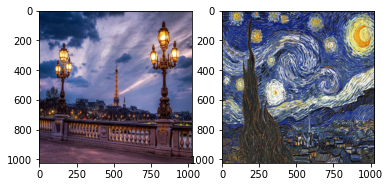

In [ ]:
content = cv2.resize(cv2.imread("./original.jpeg"), (1024,1024))
content = tf.image.convert_image_dtype(content, tf.float32)
style = cv2.resize(cv2.imread("./style.jpeg"), (1024,1024))
style = tf.image.convert_image_dtype(style, tf.float32)
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(np.array(content), cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(np.array(style), cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
opt = tf.optimizers.Adamax(learning_rate=0.01)

In [ ]:
def lossObject(styleOut, contentOut, styleTarget, contentTarget):
    styleWeight = 1e-2
    contentWeight = 1e-1
    contentLoss = tf.reduce_mean((contentOut - contentTarget) **2)
    styleLoss = tf.add_n([tf.reduce_mean((_out - _target) **2) for _out, _target in zip(styleOut, styleTarget)])
    loss = contentWeight*contentLoss + styleWeight*styleLoss
    return loss


In [ ]:
vggModel = loadVGG()
contentTarget = vggModel(np.array([content*255]))[0]
styleTarget = vggModel(np.array([style*255]))[1]



80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
def train(image, epoch):
    with tf.GradientTape() as tape:
        output = vggModel(image*255)
        loss = lossObject(output[1], output[0], styleTarget, contentTarget)
    gradient = tape.gradient(loss, image)
    opt.apply_gradients([(gradient, image)])
    image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))

    if epoch % 100 == 0:
        tf.print(f"Epoch = {epoch} - Loss = {loss}")

In [ ]:
EPOCHS = 4000
image = tf.image.convert_image_dtype(content, tf.float32)
image = tf.Variable([image])
for i in range(EPOCHS):
    train(image, i)

Epoch = 0 - Loss = 2397204224.0
Epoch = 100 - Loss = 13431120.0
Epoch = 200 - Loss = 7729793.0
Epoch = 300 - Loss = 5494606.5
Epoch = 400 - Loss = 4217766.0
Epoch = 500 - Loss = 3365750.25
Epoch = 600 - Loss = 2749976.0
Epoch = 700 - Loss = 2285889.25
Epoch = 800 - Loss = 1927381.25
Epoch = 900 - Loss = 1647452.0
Epoch = 1000 - Loss = 1426353.375
Epoch = 1100 - Loss = 1249256.25
Epoch = 1200 - Loss = 1105539.875
Epoch = 1300 - Loss = 987154.125
Epoch = 1400 - Loss = 888045.75
Epoch = 1500 - Loss = 803533.6875
Epoch = 1600 - Loss = 730284.8125
Epoch = 1700 - Loss = 666039.3125
Epoch = 1800 - Loss = 609049.0625
Epoch = 1900 - Loss = 558165.4375
Epoch = 2000 - Loss = 512525.03125
Epoch = 2100 - Loss = 471405.0625
Epoch = 2200 - Loss = 434361.53125
Epoch = 2300 - Loss = 400964.0
Epoch = 2400 - Loss = 370839.0625
Epoch = 2500 - Loss = 343647.84375
Epoch = 2600 - Loss = 319165.96875
Epoch = 2700 - Loss = 297141.59375
Epoch = 2800 - Loss = 277333.21875
Epoch = 2900 - Loss = 259534.8125
Epoch 

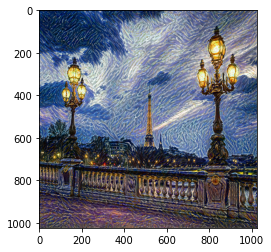

In [ ]:
import PIL

tensor = image*255
tensor = np.array(tensor, dtype=np.uint8)
if np.ndim(tensor) > 3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
tensor = PIL.Image.fromarray(tensor)
plt.imshow(cv2.cvtColor(np.array(tensor), cv2.COLOR_BGR2RGB))
plt.show()
plt.imsave("./output.png", cv2.cvtColor(np.array(tensor), cv2.COLOR_BGR2RGB))